In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Задаем трансформации для данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем изображения в тензоры
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])


In [3]:
# Загружаем обучающий и тестовый наборы данных
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Проверяем размерность данных
print(f'Размер обучающего набора: {trainset.data.shape}')
print(f'Размер тестового набора: {testset.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Размер обучающего набора: (50000, 32, 32, 3)
Размер тестового набора: (10000, 32, 32, 3)


In [4]:
# Визуализируем несколько изображений
def imshow(img):
    img = img / 2 + 0.5  # Де-нормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

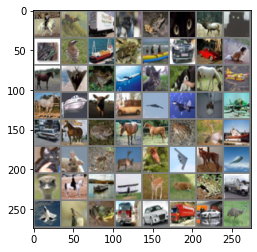

horse deer  truck bird 


In [5]:
# Получаем случайные изображения
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Показываем изображения и их метки
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(4)))

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        self.downsample = downsample


    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return torch.relu(out)


In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)


Using device: cuda:0


In [9]:
import time
# Гиперпараметры
batch_size = 64
learning_rate = 0.01
num_epochs = 20



# Обучение сети
all_predictions = 0
correct_predictions = 0
train_loss = []
for epoch in range(num_epochs):
    start_time = time.time()
    net.train()
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
            
        optimizer.zero_grad()
        outputs = net(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()
            
        running_loss += loss.item()

        _, predictions = torch.max(outputs.data, dim=1)
        all_predictions += labels.size(0)
        correct_predictions += (predictions == labels).sum().item()       
        
    avg_loss = running_loss / len(trainloader)
    train_loss.append(avg_loss)
    epoch_accuracy = correct_predictions / all_predictions

       
    end_time = time.time()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f},  Epoch time: {(end_time - start_time):.4f} sec')
    

print('Обучение завершено.')

Epoch [1/20], Loss: 1.3070, Accuracy: 0.5310,  Epoch time: 20.9686 sec
Epoch [2/20], Loss: 0.7583, Accuracy: 0.6314,  Epoch time: 18.8455 sec
Epoch [3/20], Loss: 0.5436, Accuracy: 0.6906,  Epoch time: 18.8446 sec
Epoch [4/20], Loss: 0.4150, Accuracy: 0.7314,  Epoch time: 18.7365 sec
Epoch [5/20], Loss: 0.3101, Accuracy: 0.7633,  Epoch time: 18.8637 sec
Epoch [6/20], Loss: 0.2438, Accuracy: 0.7885,  Epoch time: 18.6542 sec
Epoch [7/20], Loss: 0.1738, Accuracy: 0.8100,  Epoch time: 19.6185 sec
Epoch [8/20], Loss: 0.1328, Accuracy: 0.8279,  Epoch time: 20.1564 sec
Epoch [9/20], Loss: 0.1041, Accuracy: 0.8430,  Epoch time: 20.4490 sec
Epoch [10/20], Loss: 0.0828, Accuracy: 0.8559,  Epoch time: 20.4383 sec
Epoch [11/20], Loss: 0.0733, Accuracy: 0.8668,  Epoch time: 20.2084 sec
Epoch [12/20], Loss: 0.0681, Accuracy: 0.8759,  Epoch time: 20.4324 sec
Epoch [13/20], Loss: 0.0461, Accuracy: 0.8844,  Epoch time: 19.6576 sec
Epoch [14/20], Loss: 0.0378, Accuracy: 0.8918,  Epoch time: 20.4090 sec
E

In [10]:
# Оценка на тестовом наборе данных
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Перенос данных на GPU

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Точность на тестовом наборе: {100 * correct / total:.2f}%')

Точность на тестовом наборе: 83.45%


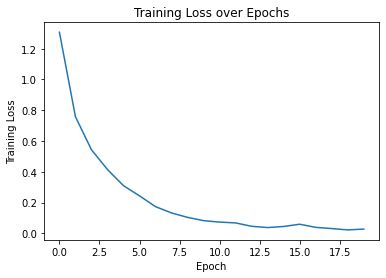

In [11]:
# График ошибки обучения
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()